In this file, we compute the gradients for the toy expectation
$$
\mathbb{E}_{\mathbf{X} \sim p(\mathbf{X})}\left[
    |\mathbf{X} - b|
\right],
$$
where we randomly selected $b$ from the sample space of $p(\mathbf{X})$. In this case, $p(\mathbf{X})$ is a multivariate categorical factorising in `DIM` independent components of dimension `CATS`. Hence, we start by choosing value for both these parameters, keeping in mind that we want to compare to the exact gradient.

For our experiments, we considered the following choices:

1. `DIMS = 12` and `CATS = 3`
2. `DIMS = 6`  and `CATS = 10`
3. `DIMS = 3`  and `CATS = 100`

For a closer look at the specific implementation of each gradient type, consider exploring jointcategorical.py.

In [7]:
import os
import time
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt

from losses import abs_loss, sq_loss
from jointcategorical import JointCategorical


os.environ["CUDA_VISIBLE_DEVICES"] = "3"

DIM = 3
CATS = 100
SAMPLES = 1000
TEMP = 1.
RUNS = 1000

Here we introduce the colours necessary for the final plots.

In [8]:
red_salsa = '#F94144'  # main red colour
celadon_blue = '#277DA1'  # main blue colour

We start by explicitly computing the exact gradient through exact enumeration and automatic differentiation.

In [9]:
joint = JointCategorical(DIM, CATS, SAMPLES, temp=TEMP)

""" Exact gradients """
exact_time = time.time()
with tf.GradientTape() as tape:
    target_probs = joint.call(1)
    joint_options = joint.options()
    exact_loss = tf.reduce_sum(abs_loss(joint_options, target_probs) * joint.joint_probs(joint_options, joint.logits), axis=0)
    exact_g = tape.gradient(exact_loss, joint.logits)
    exact_t = time.time() - exact_time

Each of the following cells computes approximations of the above exact gradient via different methods. All methods use `SAMPLES` samples, except IndeCateR, which is why the cell for IndeCateR starts by putting the number of samples to 1. Additionally, calling the method `joint.icr_multiplier()` construct a tensor that allows efficient computation of the IndeCateR gradients.
At the end we set the number of samples back to the original value, being 1000 in our experiments.

In [10]:
""" IndeCateR gradients """
joint.samples = 1
joint.indecater_multiplier()
def indecater_grads():
    icr_time = time.time()
    _, g = joint.indecater_grads(abs_loss, target_probs)
    return g, time.time() - icr_time

icr_g = []
icr_t = []
for i in range(RUNS):
    g, t = indecater_grads()
    icr_g.append(g)
    icr_t.append(t)
icr_g = tf.stack(icr_g)
icr_t, icr_t_ste = np.mean(icr_t), np.std(icr_t) / np.sqrt(RUNS)
print("IndeCateR time: ", icr_t, "+/-", icr_t_ste)
joint.samples = SAMPLES

IndeCateR time:  0.00033124303817749025 +/- 0.00012115429824210488


In [11]:
""" GS gradients """
def gs_grads():
    gs_time = time.time()
    _, g = joint.gs_grads(abs_loss, target_probs)
    return g, time.time() - gs_time

gs_g = []
gs_t = []
for i in range(RUNS):
    g, t = gs_grads()
    gs_g.append(g)
    gs_t.append(t)
gs_g = tf.stack(gs_g)
gs_t, gs_t_std = np.mean(gs_t), np.std(gs_t) / np.sqrt(RUNS)
print("GS time: ", gs_t, "+/-", gs_t_std)

GS time:  0.0015829648971557616 +/- 0.00013725739014140354


In [12]:
""" REINFORCE gradients """
def reinforce_grads():
    start_time = time.time()
    _, g = joint.reinforce_grads(abs_loss, target_probs)
    return g, time.time() - start_time

reinforce_g = []
reinforce_t = []
for i in range(RUNS):
    g, t = reinforce_grads()
    reinforce_g.append(g)
    reinforce_t.append(t)
reinforce_g = tf.stack(reinforce_g)
reinforce_t_m = np.mean(reinforce_t)
reinforce_t_std = np.std(reinforce_t) / np.sqrt(RUNS)
print("REINFORCE time: ", reinforce_t_m, "+/-", reinforce_t_std)

REINFORCE time:  0.0009134726524353027 +/- 0.00011286008818747992


In [13]:
""" REINFORCE LOO gradients """
def rloo_grads():
    start_time = time.time()
    _, g = joint.rloo_grads(abs_loss, target_probs)
    return g, time.time() - start_time

rloo_g = []
rloo_t = []
for i in range(RUNS):
    g, t = rloo_grads()
    rloo_g.append(g)
    rloo_t.append(t)
rloo_g = tf.stack(rloo_g)
rloo_t_m = np.mean(rloo_t)
rloo_t_std = np.std(rloo_t) / np.sqrt(RUNS)
print("RLOO time: ", rloo_t_m, "+/-", rloo_t_std)

RLOO time:  0.0009484086036682129 +/- 0.00012809373116021272


Having computed the gradients `RUNS` number of times, we plot the average bias and the variance of the cosine similarity of the approximated gradients and the exact gradients.

ValueError: labels argument cannot be None when kwargs are passed

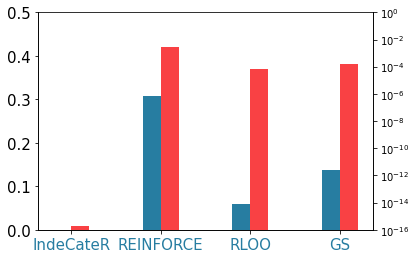

In [14]:
gradients = {'Exact': exact_g, 
             'IndeCateR': icr_g,
            'REINFORCE': reinforce_g, 
            'RLOO': rloo_g, 
            'GS': gs_g}
x = ["IndeCateR", "REINFORCE", "RLOO", "GS"]
x_axis = tf.cast(tf.range(4), dtype=tf.float32)

bias = [tf.reduce_mean(1.0 + tf.keras.losses.cosine_similarity(tf.reshape(exact_g, [-1, DIM * CATS]), tf.reshape(gradients[estimator], [-1, DIM * CATS]))) for estimator in x]
variance = [tf.math.reduce_variance(tf.keras.losses.cosine_similarity(tf.reshape(exact_g, [-1, DIM * CATS]), tf.reshape(gradients[estimator], [-1, DIM * CATS]))) for estimator in x]

fig, ax1 = plt.subplots();
lns1 = ax1.bar(x_axis - 0.2 / 2, bias, color=celadon_blue, width=0.2, label='Bias')
ax1.set_ylim([0, 0.5])
ax1.set_xticks(x_axis, x, fontsize=15, color=celadon_blue)
ax1.spines[['top']].set_visible(False)
plt.yticks(fontsize=15)

ax2 = plt.twinx()
lns3 = ax2.bar(x_axis + 0.2 / 2, variance, color=red_salsa, width=0.2, label='Variance')
ax2.set_yscale('log')
ax2.set_ylim([1e-16, 1])
ax2.set_yticks([1e-16, 1e-8, 1e-4, 1e-2, 1e-1], color=red_salsa)
ax2.spines[['top']].set_visible(False)
plt.yticks(fontsize=15)

plt.legend([lns1, lns3], ['Bias', 'Variance'], loc='upper left', frameon=False, fontsize=15)
plt.xticks(x_axis, x)
plt.savefig(f'/cw/dtaijupiter/NoCsBack/dtai/lennert/CATSCH/synthetic/plots/bias_variance_d{DIM}_c{CATS}_s{SAMPLES}_runs{RUNS}_temp{TEMP}.pdf', bbox_inches='tight', dpi=300, transparent=True)
plt.show()